In [1]:
from sklearn import svm
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn.kernel_approximation as ka
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.datasets import make_circles, make_moons


sns.set(
    context="notebook",
    style="whitegrid",
    rc={"figure.dpi": 120, "scatter.edgecolors": "k"},
)


# Uebung 8 SVM & Clustering

### Hilfsmethoden

In [2]:
cache = {}


def plot_support_vectors(X, y, clf, title=None):
    # plot the line, the points, and the nearest vectors to the plane
    plt.figure()
    plt.clf()

    plt.scatter(
        clf.support_vectors_[:, 0],
        clf.support_vectors_[:, 1],
        s=90,
        facecolors="none",
        zorder=10,
        edgecolors="k",
    )
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired, edgecolors="k")

    plt.axis("tight")

    x_min, x_max = X[:, 0].min() * 0.90, X[:, 0].max() * 1.1
    y_min, y_max = X[:, 1].min() * 0.90, X[:, 1].max() * 1.1

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(
        XX,
        YY,
        Z,
        colors=["k", "k", "k"],
        linestyles=["--", "-", "--"],
        levels=[-1, 0, 1],
    )

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xticks(())
    plt.yticks(())
    if title:
        plt.title(title)
    plt.show()

# Plot a set of digits
def plot_digits(data, title):
    fig, axes = plt.subplots(
        4,
        10,
        figsize=(10, 4),
        subplot_kw={"xticks": [], "yticks": []},
        gridspec_kw=dict(hspace=0.1, wspace=0.1),
    )
    for i, ax in enumerate(axes.flat):
        ax.imshow(
            data[i].reshape(8, 8), cmap="binary", interpolation="nearest", clim=(0, 16)
        )

    plt.suptitle(title)
    plt.show()

class MidpointNormalize(Normalize):
    """Source: https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html"""

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


def visualize_gridsearch(
    gs, range_a, range_b, xlabel, ylabel, title, logx=False, fignum="121", cbar=False
):
    scores = gs.cv_results_["mean_test_score"].reshape(len(range_a), len(range_b))
    plt.subplot(fignum)
    plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(
        scores,
        interpolation="nearest",
        cmap=plt.cm.hot,
        norm=MidpointNormalize(vmin=0.1, midpoint=0.95),
    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if cbar:
        plt.colorbar()
    plt.yticks(
        np.arange(len(range_a)), ["$2^{" + str(int(x)) + "}$" for x in np.log2(range_a)]
    )
    if logx:
        plt.xticks(
            np.arange(len(range_b)),
            ["$2^{" + str(int(x)) + "}$" for x in np.log2(range_b)],
            rotation=45,
        )
    else:
        plt.xticks(np.arange(len(range_b)), range_b, rotation=45)
    plt.title(title)
    plt.grid(False)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

def plot_decision_boundary(model, X, y):
    """Create a decision boundary plot that shows the predicted label for each point."""
    h = 0.05  # step size in the mesh

    # Create color maps
    cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])
    cmap_bold = ListedColormap(["#FF0000", "#00FF00", "#0000FF"])

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    k = model.n_neighbors
    if k in cache:
        Z = cache[k]
    else:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        cache[k] = Z

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor="k", s=20)
    plt.title("2D Iris KNN Decision Boundaries ($k=%s$)" % k)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

def plot_kmeans(X, k, title, subplot=None):
    """# Helper function to run K-Means with given k and plot clustering"""
    # Run K-Means
    labels, centers = fit_kmeans(X=X, k=k)

    # Plot resulting clustering
    plot_clustering(X, labels, centers, title, subplot)

## 1) SVM


### Daten Generierung

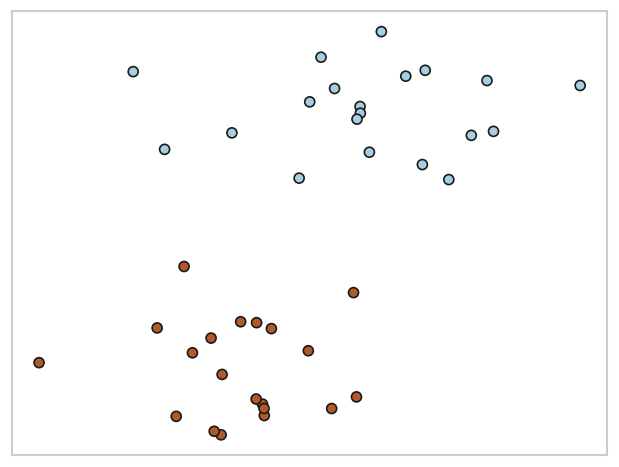

In [3]:
# Generate data
def plot_data(X, y):
    """Plots the data and label assignment as a scatter plot."""
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors="k", zorder=10)
    plt.xticks([])
    plt.yticks([])
    plt.axis("tight")
    plt.show()


np.random.seed(0)

X_lin, y_lin = datasets.make_blobs(n_samples=40, centers=2, random_state=6)

plot_data(X_lin, y_lin)

### 1a) Lineare Kernel

Beginnen wir damit den gegebenen linearen separierbaren Datensatz, der aus zwei Klassen-Clustern besteht mittels SVM zu trennen.
Verwenden Sie das Modul \texttt{sklearn.svm.SVC} in der Funktion \texttt{fit\_linear\_svm}, um die Stützvektoren zu finden, die die Hyperebene in den Daten definieren, und die Spanne zu den nächstgelegenen Datenpunkten maximiert.

Verwenden Sie dabei keine Regularisierung ($C = 10^{10}$), sodass alle Stützvektoren so definiert, dass sie die Datenpunkte sind, die auf dem Rand der Spanne liegen und den exakt gleichen orthogonalen Abstand zur trennenden Hyperebene (den Randwert) haben.

In [6]:
def fit_linear_svm(X, y):
    """Fits a svm with a linear kernel and no regularization to the data."""
    clf = svm.SVC(C=10**10, kernel="linear")
    clf.fit(X=X, y=y)
    return clf

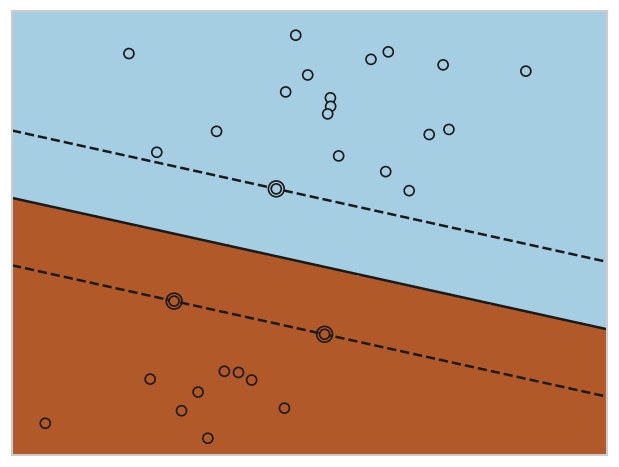

In [7]:
# Create an SVC object with a linear kernel (and no regularization)
# Fit the hyperplane to the data
clf = fit_linear_svm(X_lin, y_lin)

# Plot data with hyperplane and support vectors
plot_support_vectors(X_lin, y_lin, clf)

### 1b) Kernel-Trick

SVMs erlauben die Verwendung des sogenannten _Kernel-Tricks_ für Probleme, die nicht wie oben angenommen linear trennbar sind, d.h. die Berechnung des Vektorprodukts in einem Merkmalsraum, in welchem die Daten erneut linear seperarierbar sind. Bekannte Kernel sind:

- Linear Kernel
- _d_-Grad-Polynom-Kernel
- Radiale Basisfunktionskernel (RBF)

Wir müssen daher eine Hyperebene in einem anderen Kernelraum finden, in dem die Daten wieder trennbar werden. Verwenden wir nun den radialen Basisfunktion Kernel $k_{rbf}(\mathbf{x}_i, \mathbf{x}_j) = \exp( - \frac{||\mathbf{x}_i - \mathbf{x}_j|||^2}{2 \sigma^2})$ in der Methode `fit_rbf_svm` um unseren Merkmalsraum zu transferieren.

Hinweis: Sklearn hat diesen Kernel bereits implementiert.

### Daten Generierung


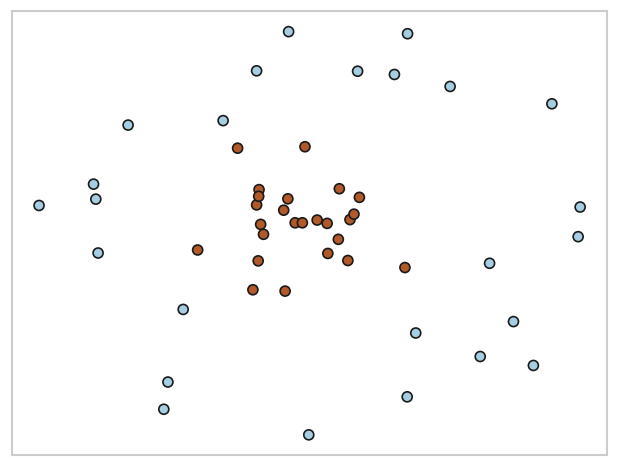

In [8]:
# Create circles dataset
X_circ, y_circ = datasets.make_circles(
    n_samples=50, noise=0.2, random_state=6, factor=0.01
)

# Plot
plot_data(X_circ, y_circ)

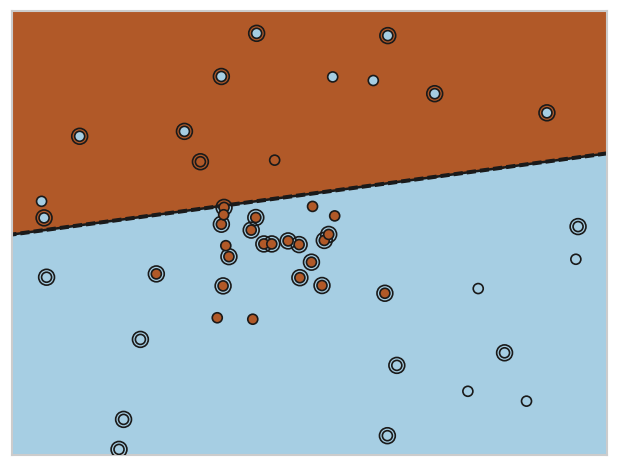

In [9]:

# Create an SVC object with the linear kernel parameter
clf = fit_linear_svm(X_circ, y_circ)

# Plot data with hyperplane and support vectors
plot_support_vectors(X_circ, y_circ, clf)


In [12]:
def fit_rbf_svm(X, y):
    """Fits a svm with a rbf kernel and no regularization to the data."""
    clf = svm.SVC(C=10**10, kernel="rbf", gamma="auto")
    clf.fit(X=X, y=y)
    return clf


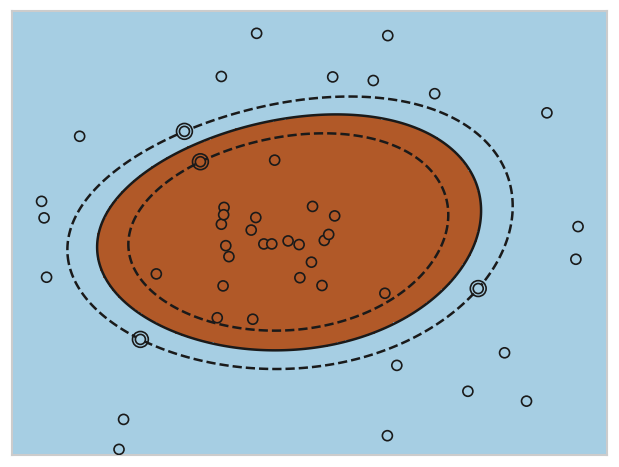

In [13]:
# Create an SVC object with the rbf kernel parameter
clf = fit_rbf_svm(X_circ, y_circ)

# Plot data with hyperplane and support vectors
plot_support_vectors(X_circ, y_circ, clf)

### 1c) Regularisierung

Ein weiterer wichtiger Hyperparameter für die SVM ist die Regularisierung. Die SVM-Optimierung versucht, Datenpunkte zu finden, die die Spanne definieren. Dies ist nicht immer die beste Lösung, da die Daten verrauscht sein können und die trennende Hyperebene das Rauschen überlagert. Daher ist es üblich, einige Datenpunkte \textbf{in} der Spanne zu erlauben, die als _Slack Variablen_ bezeichnet werden. Diese Regularisierung wird mit dem _C_ Parameter in `svm.SVC(...)` implementiert. Das sind die Kosten, die entstehen, wenn man zulässt, dass Supportvektoren innerhalb des Spannraums liegen. Die Zuweisung hoher Kosten (z.B. _C=1e10_) wird dazu führen, dass keine Datenpunkte innerhalb der Spanne liegen, während die Zuweisung niedriger Kosten (z.B. _C=1e-1_) zu einer weniger strengen Spanne führt.

Visualisieren Sie die Entscheidungsregionen und Support-Vektoren für $C=[2^{-6}, 2^{-3}, 1, 2^3, 2^6, 2^{12}]$ in der Methode `plot_svm_C`.
Sie können dabei auf die Funktion `plot_support_vectors` zurückgreifen.




In [16]:
def plot_svm_C(X, y):
    """Plot the decision boundaries and support vectors for regularization constants:
    C=[2^-6, 2^-3, 1, 2^3, 2^6, 2^12]."""
    C=[2**(-6), 2**(-3), 1, 2**3, 2**6, 2**12]
    # min = -6, max = 12
    for reg in C:
    # loop
        # Create an SVC object with the rbf kernel parameter
        clf = svm.SVC(C=reg, kernel="rbf", gamma="auto")

        # Fit the hyperplane to the data
        clf.fit(X=X, y=y)

        # Plot data with hyperplane and support vectors
        print(f"Regulation Parameter == {reg}")
        plot_support_vectors(X=X, y=y, clf=clf)


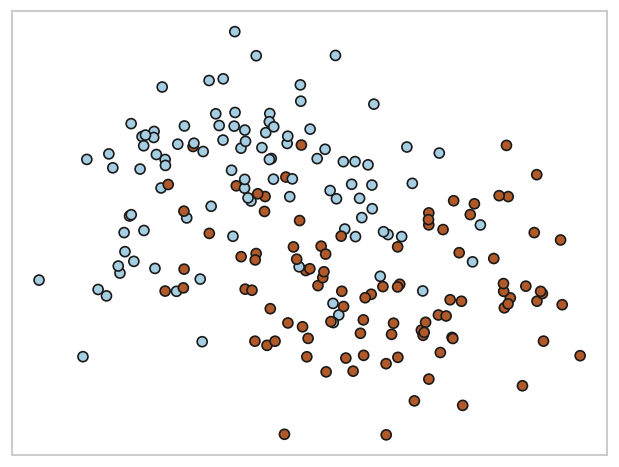

Regulation Parameter == 0.015625


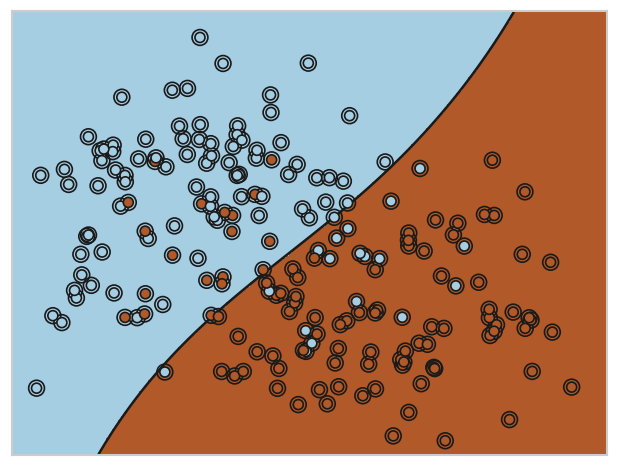

Regulation Parameter == 0.125


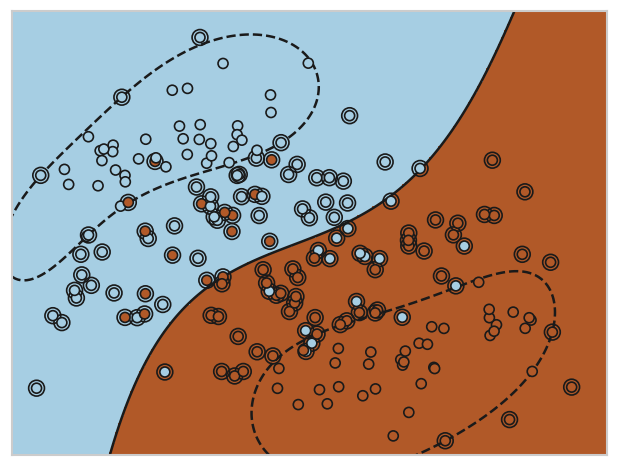

Regulation Parameter == 1


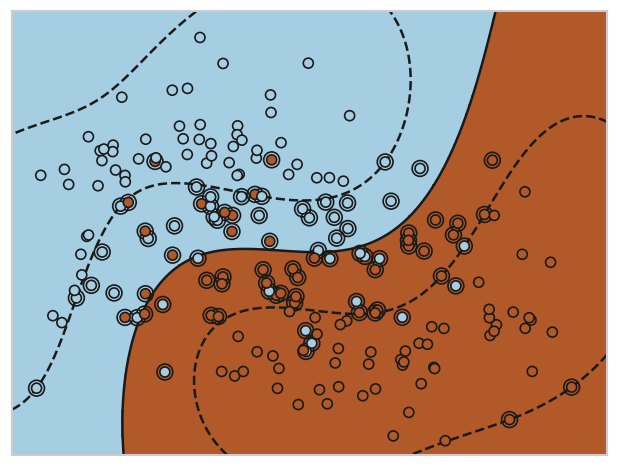

Regulation Parameter == 8


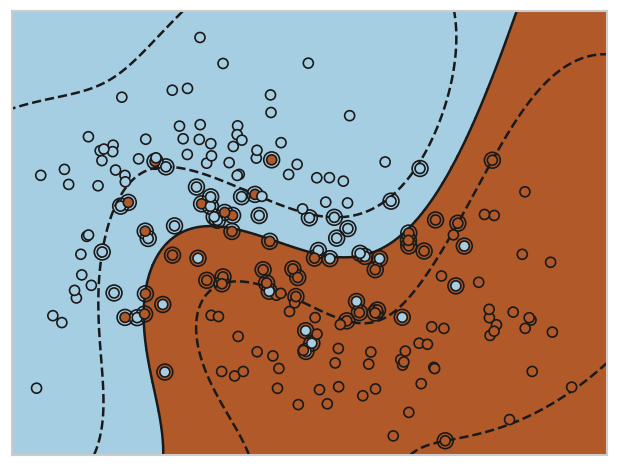

Regulation Parameter == 64


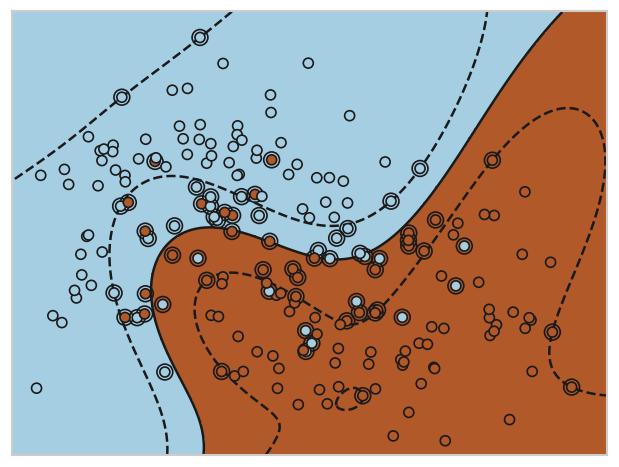

Regulation Parameter == 4096


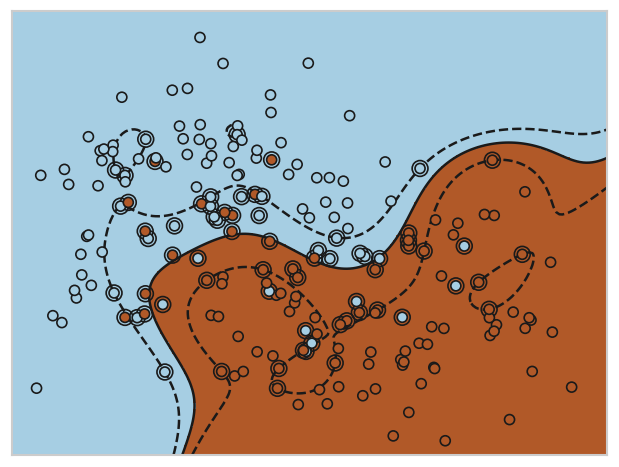

In [17]:

# Generate the two moons dataset
X_moons, y_moons = datasets.make_moons(200, noise=0.4, random_state=6)
# Plot the data
plot_data(X_moons, y_moons)
plot_svm_C(X_moons, y_moons)

## 2) SVM Multi-Label Klassifikation

### Dataset Generierung

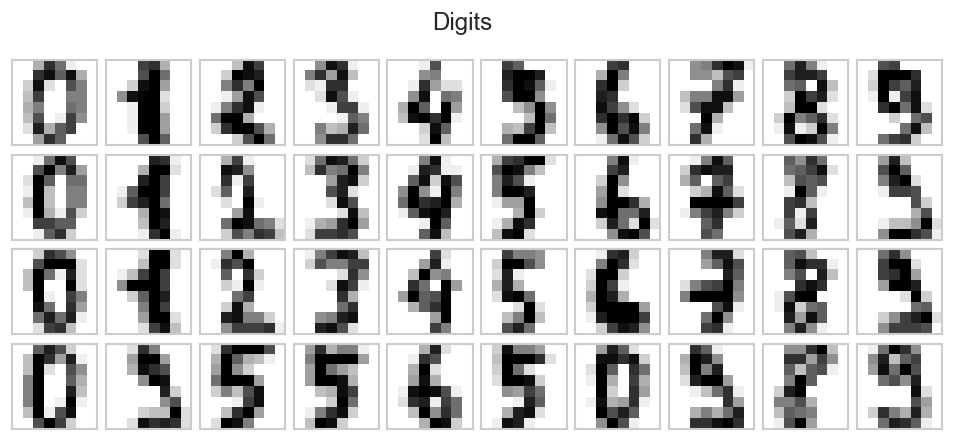

In [18]:
# Load digits
X_digits, y_digits = datasets.load_digits(return_X_y=True)

# Show data
plot_digits(X_digits, title="Digits")


### 2a) SVM Gridsearch
Wir werden den Zifferndatensatz verwenden, um die Genauigkeit der SVM in Bezug auf die verschiedenen Hyperparameter-Setups zu messen.

Support-Vektor-Maschinen sind leistungsfähige Klassifikatoren. Es ist wichtig, eine Menge von Hyperparametern zu finden, die gut zu den Daten passen. Dazu ist es üblich, eine Hyperparametersuche z.B. über eine Gridsearch durchzuführen, das sich über mögliche Werte für verschiedene Parameter erstreckt. Für den RBF-Kernel können wir z.B. ein Gridsearch mit den Parametern _C_ und $\gamma$ abdecken, was effektiv jede Kombination beider Parameterbereiche aufbaut.

Führen Sie eine Gridsearch in der Methode `run_grid_search` für die Bereiche $2^{-13} \leq \gamma \leq 2^{-4}$, $2^{-3} \leq C \leq 2^{3}$, $1 \leq d \leq 6$ durch. Sie können dabei die Funktion `sklearn.model_selection.GridSearchCV` verwenden.

In [21]:
def run_grid_search(X_digits, y_digits, C_range, degree_range, gamma_range):
    """Defines and runs a grid search over the given hyperparameter ranges for
    rbf and polynomial kernel. Each run is evaluated by using a 5-fold-cross-validation."""
    # Define grid over parameters for rbf and poly kernel
    rbf_param = {"kernel": ["rbf"], "C": C_range, "gamma": gamma_range}
    poly_param = {"kernel": ["poly"], "C": C_range, "degree": degree_range}

    # GridSearch arguments
    estimator=svm.SVC()
    scoring=make_scorer(accuracy_score)
    cv=5
    verbose=1

    # Run gridsearch on the RBF grid
    rbf_gs = GridSearchCV(estimator=estimator, 
                          param_grid=rbf_param, 
                          scoring=scoring, 
                          cv=cv,
                          verbose=verbose)
    rbf_gs.fit(X=X_digits, y=y_digits)
    
    
    poly_gs = GridSearchCV(estimator=estimator, 
                          param_grid=poly_param, 
                          scoring=scoring, 
                          cv=cv,
                          verbose=verbose)
    poly_gs.fit(X=X_digits, y=y_digits)


    return poly_gs, rbf_gs


Fitting 5 folds for each of 63 candidates, totalling 315 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits


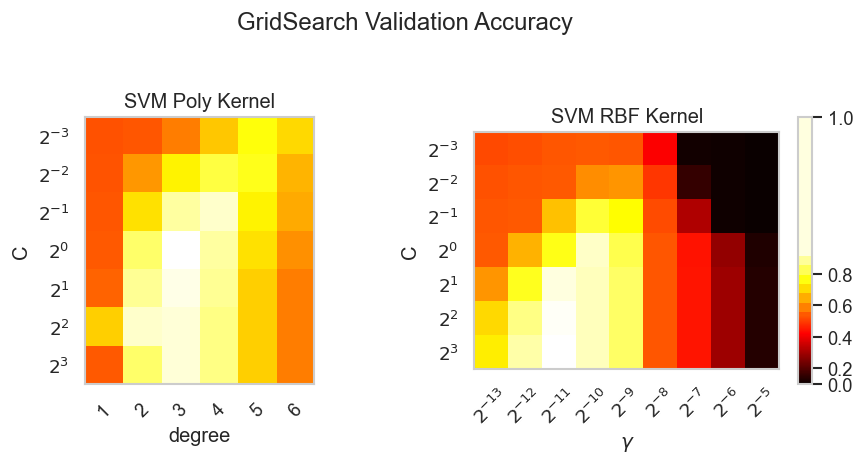

In [23]:
# Define hyperparameter ranges
gamma_range = [2 ** i for i in range(-13, -4)]
C_range = [2 ** i for i in range(-3, 4)]
degree_range = range(1, 7)

poly_gs, rbf_gs = run_grid_search(X_digits, y_digits, C_range, degree_range, gamma_range)

# Visualize the gridsearch results
plt.figure(figsize=(8, 4))
plt.suptitle("GridSearch Validation Accuracy")
visualize_gridsearch(
    poly_gs,
    C_range,
    degree_range,
    ylabel="C",
    xlabel="degree",
    title="SVM Poly Kernel",
    fignum=121,
)
visualize_gridsearch(
    rbf_gs,
    C_range,
    gamma_range,
    ylabel="C",
    xlabel="$\gamma$",
    title="SVM RBF Kernel",
    logx=True,
    fignum=122,
    cbar=True,
)
plt.show()

## 3) K-Means Clustering

### 3a) Datensatzvisualisierung

Beginnen wir mit einem Beispieldatensatz, der aus drei getrennte Cluster besteht.
Wenden Sie auf diesen K-Means Clustering an (`fit_kmeans`).
Stellen Sie anschließend die gefundenen Cluster in der Methode `plot_clustering` dar.


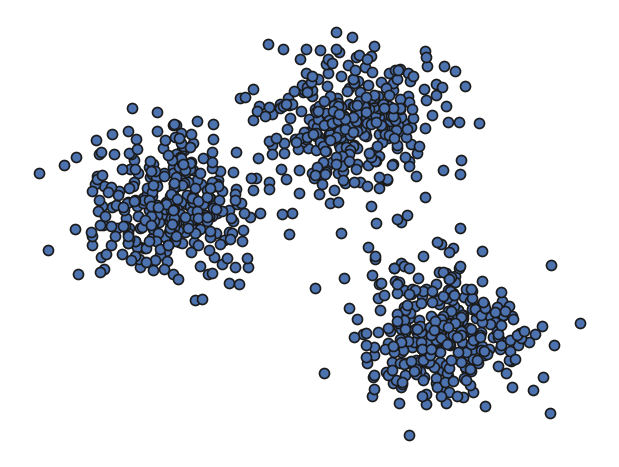

In [24]:
# Generate three clusters
X, y = make_blobs(
    n_samples=1000, centers=3, cluster_std=0.6, n_features=2, random_state=0
)

def plot_cluster_data(X):
    """Creates a scatter plot for the given data."""
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1])
    plt.axis("off")
    plt.show()

# Plot data
plot_cluster_data(X)


In [25]:

def fit_kmeans(X, k, init="k-means++", n_init=10, random_state=0) -> [np.ndarray, np.ndarray]:
    """Runs K-Means clustering and returns the label assignments and cluster centroids."""
    # Build K-Means model
    kmeans = KMeans(n_clusters=k, init=init, n_init=n_init, random_state=random_state)

    # Fit model
    kmeans.fit(X=X)
    # Predict cluster assignment for each datapoint
    labels = kmeans.predict(X=X)

    # Get cluster centers
    centers = kmeans.cluster_centers_

    return labels, centers




In [26]:
labels, centers = fit_kmeans(X, k=3)

print(f"Labels: {labels}, {centers}")

Labels: [2 1 2 2 2 0 1 1 0 1 0 2 2 1 1 0 2 0 1 1 2 0 2 1 1 1 1 1 0 0 2 2 2 1 2 0 0
 2 0 0 0 0 1 0 0 0 0 2 1 0 1 1 0 1 1 0 0 2 2 0 2 2 2 2 1 1 0 0 2 2 1 1 1 2
 1 2 0 1 2 2 2 1 1 1 1 1 1 0 1 0 1 0 0 2 0 2 1 0 1 2 1 2 1 0 1 1 2 1 0 0 1
 1 1 1 2 2 1 2 1 0 1 0 2 1 1 0 2 2 2 1 1 2 1 1 2 1 1 0 2 2 1 1 1 2 2 2 1 1
 2 1 1 2 1 1 1 2 1 0 0 2 1 1 1 1 1 1 2 1 0 0 0 2 2 2 2 1 0 1 1 2 1 1 1 0 0
 1 2 0 2 1 0 2 0 2 2 1 1 2 0 0 1 2 0 1 1 2 2 2 0 1 2 1 1 1 0 2 1 2 1 1 2 1
 2 2 1 0 1 1 1 2 2 0 2 0 1 0 1 0 2 2 2 2 2 2 1 2 2 1 0 0 0 0 2 2 0 1 0 1 2
 0 1 0 0 0 1 0 2 2 2 1 2 0 2 2 2 2 1 1 2 2 0 1 0 0 0 1 2 2 0 2 1 2 0 0 0 1
 1 0 1 0 0 0 0 2 1 1 0 1 1 1 2 1 2 1 2 0 1 0 1 0 1 0 2 1 0 2 0 2 1 0 0 2 2
 2 1 2 1 2 1 0 1 0 0 2 0 0 1 0 1 0 1 1 2 2 0 2 1 1 1 1 0 2 0 0 2 2 1 2 1 0
 0 0 0 1 2 0 2 1 2 2 1 2 2 0 0 2 2 0 2 0 2 2 0 1 1 2 0 2 0 0 0 1 1 1 0 2 1
 0 0 2 1 1 2 1 2 1 0 0 0 2 2 2 0 1 1 0 2 0 0 2 1 2 1 2 2 0 2 2 0 0 1 0 1 1
 1 2 0 1 0 2 2 0 1 0 1 1 0 1 2 0 2 2 2 0 1 2 1 1 1 1 1 1 0 1 0 1 1 1 2 2 0
 2 2 2 0 0 0 0 2 

In [53]:

def plot_clustering(X, labels, centers=None, title="", subplot=None):
    """Helper function to plot the clustering"""
    # Plot in given subplot
    if subplot:
        plt.subplot(subplot)

    # Plot data with labels as color
    plt.scatter(x=X[:, 0], y=X[:, 1], c=labels, marker="o")


    # Plot centers if given
    plt.scatter(x=centers[:, 0], y=centers[:, 1], marker="*", c="blue")


    # Set title
    plt.title("Clustering of data")
    #plt.legend(scatter.legend_elements())


    #plt.axis("off")

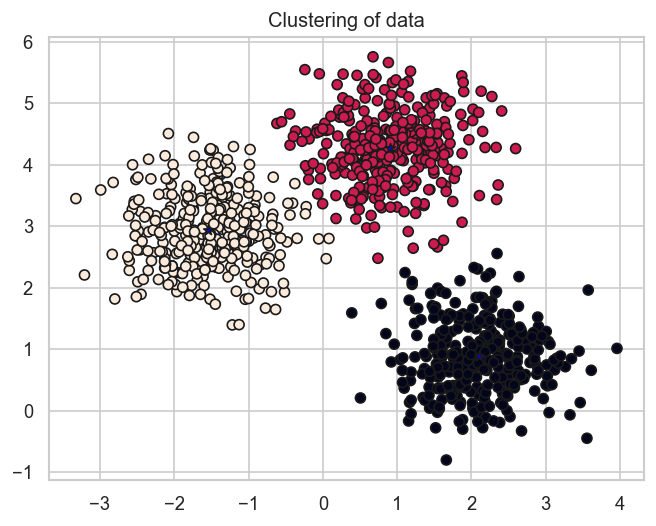

In [54]:

# Plot clustering
plt.figure()
plot_clustering(X, labels, centers)
plt.show()

## 3b) Iterationen

K-Means hat erfolgreich drei separate Cluster gefunden.

Nun möchten wir die Bewegung der Cluster-Zentroiden über die Funktion `plot_kmeans_iterations` nach jeder Iteration visualisieren.

In [55]:
def plot_kmeans_iterations(X, guess_center, initial_labels):
    """Plots the cluster assignments after iteration 1 to 6."""

    plt.figure(figsize=(2 * 3, 3 * 3))
    plot_clustering(
    X, initial_labels, centers=guess_center, title="Iteration 0", subplot=321
    )
    for i in range(1, 6):
    # Stop K-Means after i iterations
        model = KMeans(n_clusters=3, init=guess_center, n_init=1, max_iter=i).fit(X)
        labels = model.predict(X)
        centers = model.cluster_centers_

        # Plot clustering for current iteration
        plot_clustering(X, labels, centers, title="Iteration " + str(i), subplot=321 + i)
    plt.show()



In [56]:
# Generate 3 clusters
true_centers = [[0, 0], [1, 0], [0, 1]]
X, y = make_blobs(
    n_samples=900, centers=true_centers, cluster_std=0.25, n_features=2, random_state=0
)

# Generate random centers
np.random.seed(2)
guess_center = np.array(true_centers) + np.random.randn(3, 2) * 0.5



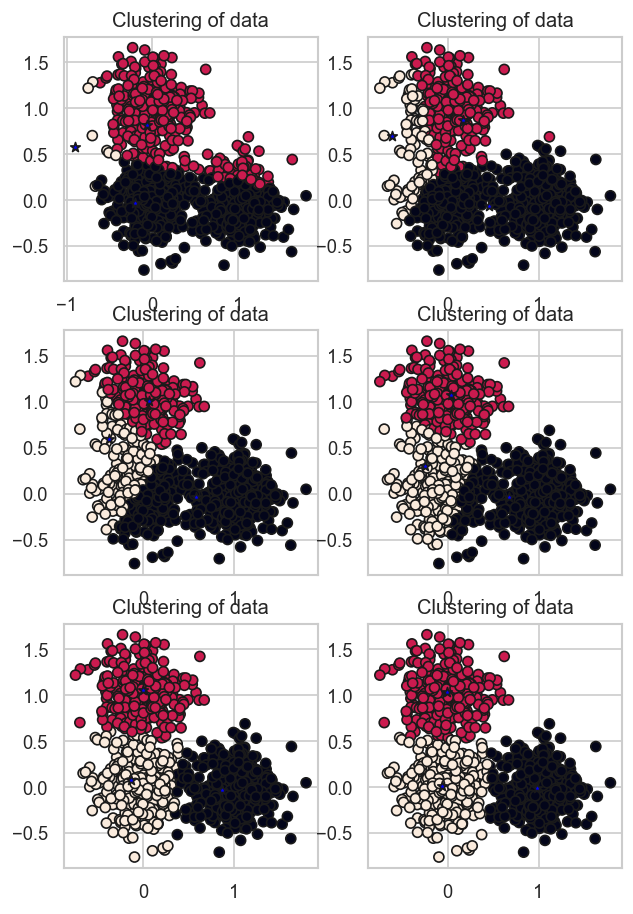

In [57]:
# For each datapoint find closest center
initial_labels = np.argmin(
    np.sqrt(((X - guess_center.reshape(3, 1, 2)) ** 2).sum(2)), 0
)

plot_kmeans_iterations(X, guess_center, initial_labels)

### Beispiele zur Wichtigkeit der Hyperparameter

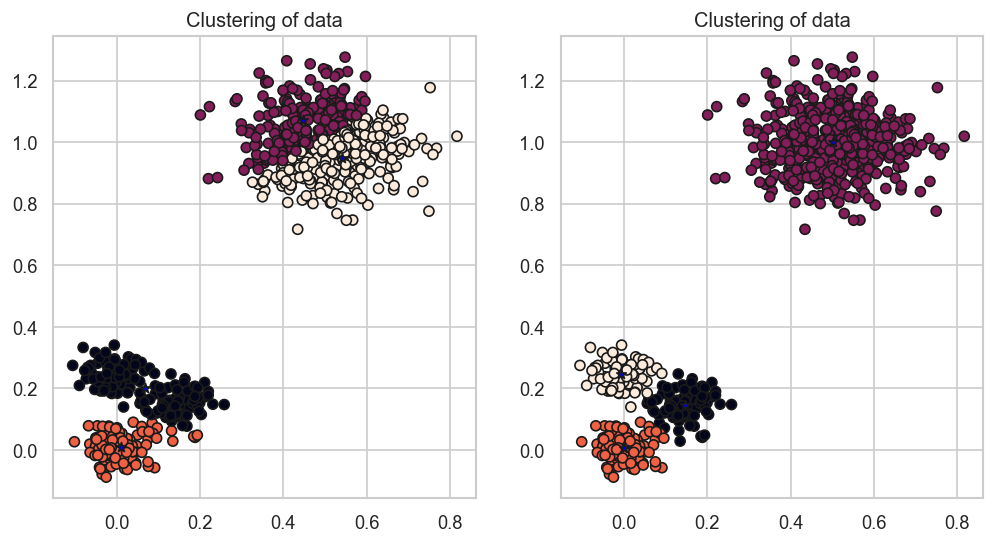

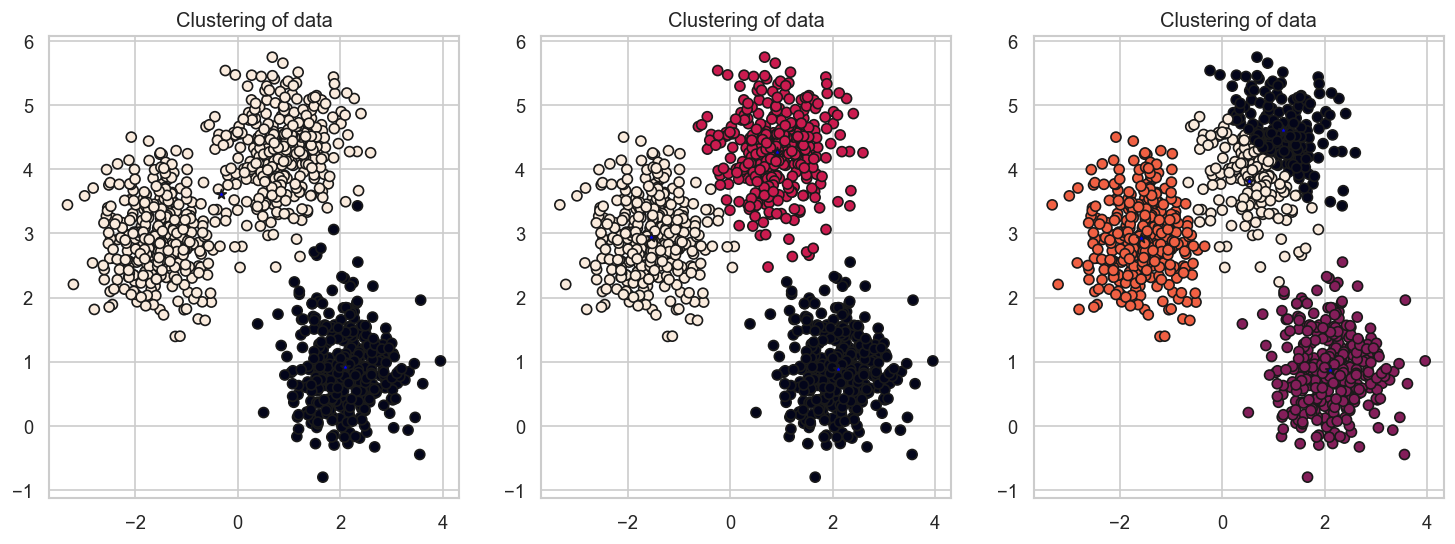

In [58]:
# Generate four clusters with custom centers
X, y = make_blobs(
    n_samples=[100, 100, 100, 500],
    centers=[[0, 0], [0, 0.25], [0.15, 0.15], [0.5, 1]],
    cluster_std=[0.04, 0.04, 0.04, 0.1],
    n_features=2,
    random_state=0,
)

# Run kmeans twice with two different random states
labels_a, centers_a = fit_kmeans(X=X, k=4, n_init=1, init="random", random_state=0)
labels_b, centers_b = fit_kmeans(X=X, k=4, n_init=1, init="random", random_state=1)

# Plot cluster assignments and cluster centers
plt.figure(figsize=(10, 5))
plot_clustering(X, labels_a, centers_a, title="Bad Clustering", subplot=121)
plot_clustering(X, labels_b, centers_b, title="Good Clustering", subplot=122)
plt.show()

# Generate three clusters
X, y = make_blobs(
    n_samples=1000, centers=3, cluster_std=0.6, n_features=2, random_state=0
)

# Run and plot
plt.figure(figsize=(15, 5))
plot_kmeans(X, k=2, title="$K=2$, Too Few", subplot=131)
plot_kmeans(X, k=3, title="$K=3$, Correct", subplot=132)
plot_kmeans(X, k=4, title="$K=4$, Too Many", subplot=133)
plt.show()

### Problematische Clustering Beispiele

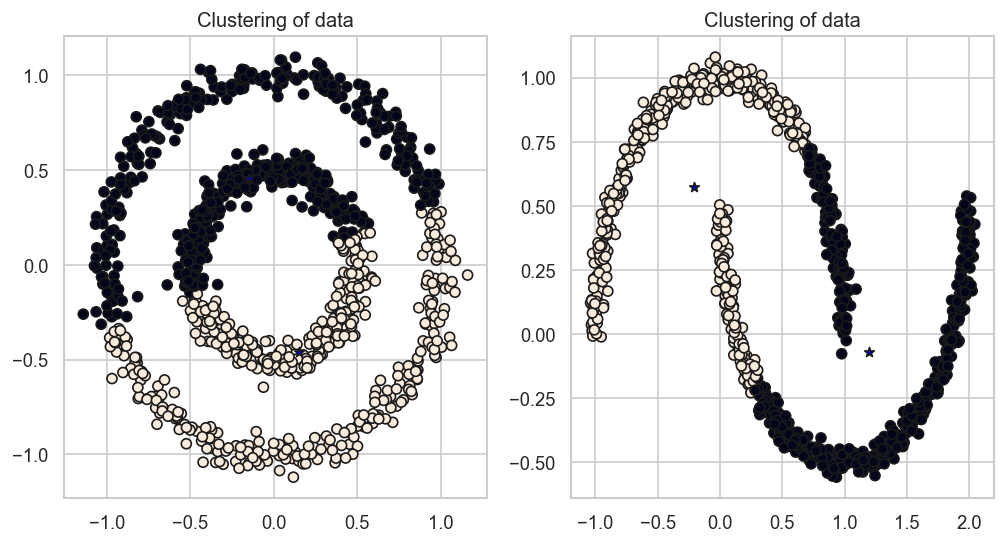

TypeError: 'NoneType' object is not subscriptable

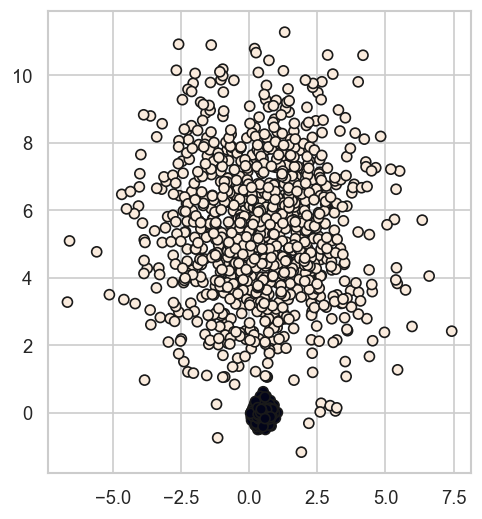

In [59]:
# Make data
X_circles, _ = make_circles(n_samples=1000, factor=0.5, noise=0.05)
X_moons, _ = make_moons(1000, noise=0.03, random_state=0)

# Run K-Means and Plot
plt.figure(figsize=(10, 5))
plot_kmeans(X_circles, k=2, title="Circles", subplot=121)
plot_kmeans(X_moons, k=2, title="Moons", subplot=122)
plt.show()

# Make clusters with different variances
X, y = make_blobs(
    n_samples=2000, centers=[[0.5, 0.0], [0.5, 5.5]], cluster_std=[0.15, 2.0]
)

# Plot true and K-Means clustering
plt.figure(figsize=(10, 5))
plot_clustering(X, labels=y, title="True Clustering", subplot=121)
plot_kmeans(k=2, X=X, title="K-Means Clustering", subplot=122)
plt.show()

# Make data
X = np.random.rand(5000, 2)

# Run and plot K-Means
plt.figure(figsize=(10, 5))
plot_clustering(X, labels=np.zeros(X.shape[0]), title="Uniform Data", subplot=121)
plot_kmeans(k=10, X=X, title="K-Means Clustering", subplot=122)
plt.show()